In [2]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist, obs_coronagraphy
from pynrc.obs_nircam import plot_contrasts, planet_mags, plot_planet_patches

from pynrc.speckle_noise import offset_bar
pynrc.setup_logging('WARNING', verbose=False)

from astropy.io import (fits, ascii)

# Observation Definitions

Functions to create at optimize a series of observation objects stored as a dictionary.

In [4]:
def make_key(filter, pupil=None, mask=None):
    """Create identification key (string) based on filter, pupil, and mask"""
    mask_key = 'none' if mask is None else mask
    pupil_key = 'none' if pupil is None else pupil
    key = '{}_{}_{}'.format(filter,mask_key,pupil_key)
    return key

In [5]:
def obs_wfe(wfe_drift, filt_list, sp_sci, dist, sp_ref=None, disk_mod=False, fov_pix=None, verbose=False):
    """
    For a given WFE drift and series of filters, create a list of 
    NIRCam observations. This function will calculate PSFs out to 320 pixels. 
    For the case of SW+MASK335R, we also assume that the subarray size matches 
    that of a simultaneous LW observation (320x320).
    """
    
    if sp_ref is None:
        sp_ref = sp_sci

    fov_pix_orig = fov_pix

    obs_dict = {}
    for filt, mask, pupil in filt_list:
        if verbose: print(filt, mask, pupil)

        # Disk Model
        if disk_mod:
            # Convert to photons/sec in specified filter
            args_disk = model_info(sp_sci.name, filt, dist)
            hdu_disk = model_to_hdulist(args_disk, sp_sci, filt, pupil=pupil, mask=mask)
        else:
            hdu_disk = None
        
        # Create identification keys
        key = make_key(filt, mask=mask, pupil=pupil)
        
        # Define the subarray readout size
        # Set the PSF size and oversampling amount
        bp = pynrc.read_filter(filt)
        subsize = 640 if bp.avgwave()/1e4 < 2.4 else 320
        fov_pix = subsize+1 if fov_pix is None else fov_pix
        oversample = 2
        
        # Initialize and store the observation
        # A reference obseration is stored inside each parent obs_coronagraphy class.
        obs_dict[key] = pynrc.obs_coronagraphy(sp_sci, sp_ref, dist, 
                                               disk_hdu=hdu_disk, wfe_drift=wfe_drift,
                                               filter=filt, mask=mask, pupil=pupil, 
                                               oversample=oversample, fov_pix=fov_pix,
                                               wind_mode='WINDOW', xpix=subsize, ypix=subsize,
                                               verbose=verbose)
        fov_pix = fov_pix_orig
        
    return obs_dict

In [6]:
def obs_optimize(obs_dict, sp_opt=None, well_levels=None, tacq_max=1800, **kwargs):
    """
    Perform ramp optimization on each science and reference observation
    in a list of filter observations. Updates the detector MULTIACCUM
    settings for each observation in the dictionary.
    
    snr_goal = 5
    snr_frac = 0.02
    tacq_max = 1400
    tacq_frac = 0.01
    nint_min = 15
    ng_max = 10
    """

    # A very faint bg object on which to maximize S/N
    # If sp_opt is not set, then default to a 20th magnitude flat source
    if sp_opt is None:
        bp_k = S.ObsBandpass('k')
        sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)

    
    # Some observations may saturate, so define a list of  maximum well level
    # values that we will incrementally check until a ramp setting is found
    # that meets the contraints.
    if well_levels is None:
        well_levels = [0.8, 1.5, 3.0, 5.0, 10.0, 20.0, 100.0, 150.0, 300.0, 500.0]
   
    filt_keys = list(obs_dict.keys())
    filt_keys.sort()
    print(['Pattern', 'NGRP', 'NINT', 't_int', 't_exp', 't_acq', 'SNR', 'Well', 'eff'])
    for j, key in enumerate(filt_keys):
        print('')
        print(key)

        obs = obs_dict[key]
        sp_sci, sp_ref = (obs.sp_sci, obs.sp_ref)
        
        # SW filter piggy-back on two LW filters, so 2 x tacq
        is_SW = obs.bandpass.avgwave()/1e4 < 2.5

        sci = obs
        ref = sci.nrc_ref

        # Ramp optimization for both science and reference targets
        for obs2, sp in zip([sci, ref], [sp_sci, sp_ref]):
            i = nrow = 0
            while nrow==0:
                well_max = well_levels[i]
                tbl = obs2.ramp_optimize(sp_opt, sp, well_frac_max=well_max, tacq_max=tacq_max, **kwargs)
                nrow = len(tbl)
                i+=1
                
            # Grab the highest ranked MULTIACCUM settings and update the detector readout
            v1, v2, v3 = tbl['Pattern', 'NGRP', 'NINT'][0]
            
            vals = tbl[0].as_void()
            strout = ', '.join(map(str, vals))
            print(strout)

            # SW filter piggy-back on two LW filters, so 2 x tacq
            is_SW = obs.bandpass.avgwave()/1e4 < 2.5
            if is_SW: v3 *= 2
            
            # Coronagraphic observations have two roll positions, so cut NINT by 2
            if obs.mask is not None: v3 = int(v3/2) 
            obs2.update_detectors(read_mode=v1, ngroup=v2, nint=v3)
        

## Plotting contrasts and planet magnitudes

Functions to plot simulated images and contrast curves

In [7]:
from copy import deepcopy

def plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=10, save_fig=False):
    nfilt = len(filt_keys)
    ext_name = ['Model', 'Sim Image (linear scale)', 'Sim Image ($r^2$ scale)']
    nim = len(ext_name)

    fig, axes = plt.subplots(nfilt, nim, figsize=(8.5,6.5))
    #axes = axes.transpose()
    for j, k in enumerate(filt_keys):
        obs = obs_dict[k]
        hdu_mod = obs.disk_hdulist
        hdu_sim = hdu_dict[k]

        # Make r^2 scaled version of data
        hdu_sim_r2 = deepcopy(hdu_sim)
        data  = hdu_sim_r2[0].data
        header = hdu_sim_r2[0].header
        rho = nrc_utils.dist_image(data, pixscale=header['PIXELSCL'])
        data *= rho**2

        # Max value for model
        data_mod   = hdu_mod[0].data
        header_mod = hdu_mod[0].header
        rho_mod    = nrc_utils.dist_image(data_mod, pixscale=header_mod['PIXELSCL'])
        data_mod_r2 = data_mod*rho_mod**2
        vmax  = np.max(data_mod)
        vmax2 = np.max(data_mod_r2)

        # Scale value for data
        mask_good = data_mod>(0.1*vmax)
        scl1 = np.median(hdu_sim[0].data[mask_good] / data_mod[mask_good])

        # Scale value for r^2 version
        mask_good = data_mod_r2>(0.1*vmax2)
        scl2 = np.median(hdu_sim_r2[0].data[mask_good] / data_mod_r2[mask_good])

        vmax_vals = [vmax,vmax*scl1,vmax2*scl2]
        hdus = [hdu_mod, hdu_sim, hdu_sim_r2]
        for i, ax in enumerate(axes[j]):
            hdulist = hdus[i]
            data = hdulist[0].data
            header = hdulist[0].header

            pixscale = header['PIXELSCL']
            rho = nrc_utils.dist_image(data, pixscale=pixscale)

            rad = data.shape[0] * pixscale / 2
            extent = [-rad, rad, -rad, rad]

            ax.imshow(data, vmin=0, vmax=0.9*vmax_vals[i], extent=extent)

            ax.set_aspect('equal')
            if i > 0: ax.set_yticklabels([])
            if j < nfilt-1: ax.set_xticklabels([])
            if j==nfilt-1: ax.set_xlabel('Arcsec')
            if j==0: ax.set_title(ext_name[i])

            if i==0: ax.set_ylabel(obs.filter)

            if fov>2*rad:
                xlim = [-rad,rad]
                ylim = [-rad,rad]
            else:
                xlim = [-fov/2,fov/2]
                ylim = [-fov/2,fov/2]
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

            ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
            ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

            ax.tick_params(axis='both', color='white', which='both')
            for k in ax.spines.keys():
                ax.spines[k].set_color('white')


    texp = obs_dict[filt_keys[-1]].multiaccum_times['t_exp']
    texp = round(2*texp/100)*100
    exp_text = "t_exp = {:.0f} sec".format(texp)
    wfe_text = "WFE Drift = {} nm".format(wfe_drift)
    fig.suptitle('{} ({}; {})'.format(name_sci, exp_text, wfe_text), fontsize=16);
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.9, bottom=0.1)
    #fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.9, bottom=0.07 , left=0.05, right=0.97)
    
    fname = "{}_images.pdf".format(name_sci.replace(" ", ""))
    if save_fig: 
        fig.savefig(outdir+fname)

## Functions to init, optimize, and plot

In [8]:
# Generate initial observations for each filter (no WFE drift)
def do_init(disk_mod=False, fov_pix=None, verbose=True):
    wfe_drift = 0
    obs_dict = obs_wfe(wfe_drift, args_list, sp_sci, dist_sci, sp_ref=sp_ref, 
                       disk_mod=disk_mod, fov_pix=fov_pix, verbose=verbose)
    return obs_dict

In [9]:
# Optimize observations
def do_opt(tacq_max, **kwargs):
    sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)
    obs_optimize(obs_dict, sp_opt=sp_opt, tacq_max=tacq_max, **kwargs)

In [10]:
# For each filter setting, generate a series of contrast curves at different WFE values
def do_contrast(wfe_list, filt_keys, nsig=5, roll_angle=None, **kwargs):
    """
    kwargs to pass to calc_contrast() and their defaults:

    exclude_disk = True
    exclude_planets = True
    exclude_noise = False
    opt_diff = True
    """
    contrast_all = {}
    for i, key in enumerate(filt_keys):
        print(key)
        obs = obs_dict[key]

        filt, mask, pupil = args_list[i]
        if roll_angle is None:
            roll_angle = 0 if mask is None else 10

        # Stores tuple of (Radial Distances, Contrast, and Sensitivity) for each WFE drift
        curves = []
        for wfe_ref_drift in wfe_list:
            obs.wfe_ref_drift = wfe_ref_drift
            result = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, **kwargs)
            curves.append(result)

        contrast_all[key] = curves
    return contrast_all

In [11]:
def do_plot_contrast(obs_dict, contrast_dict, wfe_list, nsig, age, xlim=[0,10], ylim=[24,8], save_fig=False):

    fig, axes = plt.subplots(1,2, figsize=(13,4.5))
    #entropy_vals = [13,8]

    for j, ax in enumerate(axes):
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        obs = obs_dict[filt_keys[j]]
        curves = contrast_dict[filt_keys[j]]

        plot_contrasts(curves, wfe_list, ax=ax)
        plot_planet_patches(ax, obs, age=age, entropy=13)

    for ax in axes.flatten():
        ax.set_xlabel('Distance (arcsec)')
        ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))
        ax.legend(ncol=2)

    fig.tight_layout()

    t_exp = obs.multiaccum_times['t_exp']
    t_exp = round(2*t_exp/100)*100
    fig.suptitle('{} (t_exp = {:.0f} sec)'.format(name_sci, t_exp), fontsize=16);
    #fig.subplots_adjust(top=0.85)
    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)
    
    fname = "{}_contrast.pdf".format(name_sci.replace(" ", ""))
    if save_fig: 
        fig.savefig(outdir+fname)

In [12]:
def do_gen_hdus(obs_dict, wfe_ref_drift, verbose=False, **kwargs):
    
    """
    kwargs to pass to gen_roll_image() and their defaults:
    
    PA1 = 0
    PA2 = 10
    zfact         = None
    oversample    = None
    exclude_disk  = False
    exclude_noise = False
    opt_diff      = True
    """
    
    hdulist_dict = {}
    for key in filt_keys:
        if verbose: print(key)
        obs = obs_dict[key]
        obs.wfe_ref_drift = wfe_ref_drift
        hdulist = obs.gen_roll_image(**kwargs)
        
        hdulist_dict[key] = hdulist
        
    return hdulist_dict

## Science spectral model

In [13]:
def func_model(x, sp):
    return x[0]*sp

def func_resid(x, sp_phot, sp_star, xmin=0.1e4, xmax=30e4):
    sp_model = func_model(x, sp_star)
    
    wvals = sp_phot.wave
    ind = (wvals > xmin) & (wvals < xmax)
        
    wvals = wvals[ind]
    yvals = sp_phot.flux[ind]
    
    mod_interp = np.interp(wvals, sp_star.wave, sp_model.flux)
    return 1e15*(mod_interp - yvals)

In [14]:
from scipy.optimize import least_squares
def gen_sp_sci(i, robust=False, return_ax=False, plot=True, do_ref=False,
               wmin=0.1e4, wmax=10e4):
    
    if do_ref:
        name_obj, spt_obj, kmag_obj, w1_obj, w2_obj = ref_sources[i]
    else:
        name_obj, dist_sci, fov, age, spt_obj, vmag_sci, kmag_obj, w1_obj, w2_obj = args_sources[i]
    vot = votdir + name_obj + '.vot'

    # Import source SED from VOTable
    from astropy.io.votable import parse, parse_single_table
    table = parse_single_table(vot)
    freq = table.array["sed_freq"] * 1e9 # Hz
    isort = np.argsort(1/freq)

    # Sort flux monotomically with wavelength
    freq = freq[isort]
    flux = table.array["sed_flux"][isort]
    eflux = table.array["sed_eflux"][isort]

    # Average duplicate data points
    ufreq, ucnt = np.unique(freq, return_counts=True)
    ufreq = ufreq[::-1]
    ucnt = ucnt[::-1]

    uflux = []
    for i, f in enumerate(ufreq):
        ind = (freq==f)
        flx = np.median(flux[ind]) if ucnt[i]>1 else flux[ind][0]
        uflux.append(flx)
    uflux = np.array(uflux)

    # Photometric data points
    sp_phot = S.ArraySpectrum(ufreq, uflux, waveunits='Hz', fluxunits='Jy')
    sp_phot.convert('Angstrom')
    sp_phot.convert('Flam')

    # Stellar spectrum normalized at V-Band
    sp_star = pynrc.stellar_spectrum(spt_obj, kmag_obj, 'vegamag', bp_k)

    x0 = [1]
    loss = 'soft_l1' if robust else 'linear'
    res = least_squares(func_resid, x0, bounds=(0,np.inf), loss=loss, 
                        args=(sp_phot, sp_star), kwargs={'xmin':wmin, 'xmax':wmax})
    out = res.x
    print(out)
    
    sp_sci = func_model(out, sp_star)
    sp_sci.name = name_obj

    if plot:
        fig, ax = plt.subplots(1,1, figsize=(8,5))
        ax.loglog(sp_star.wave/1e4, sp_star.flux, lw=1, label='Photosphere')
        ax.loglog(sp_sci.wave/1e4, sp_sci.flux, lw=2, label='Model Fit')
        ax.loglog(sp_phot.wave/1e4, sp_phot.flux, marker='o', ls='none', label='Photometry')
        ax.set_xlabel('Wavelength (microns)')
        ax.set_ylabel('Flux ({})'.format(sp_sci.fluxunits))
        ax.set_title(name_obj)
        fig.tight_layout()
    
        if return_ax:
            return (sp_sci, (fig,ax))
        else:
            return sp_sci
    else:
        return sp_sci


## Define Source and their Reference Counterparts

In [15]:
#                source,   dist, fov, age, sptype, vmag, kmag,  W1,  W2
args_sources = [('HR8799',  39,  14, 30,  'F0V', 5.23, 5.24, 5.19, 5.00)]

ref_sources  = [('HD220657', 'F8III', 3.04, 3.0, 2.41)]

In [16]:
# List of filters
args_list = [('F322W2', 'MASK430R', 'CIRCLYOT'),
             ('F444W',  'MASK430R', 'CIRCLYOT')]

filt_keys = []
for filt,mask,pupil in args_list:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

In [17]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [18]:
#outdir  = '/Volumes/NIRData/Andras_obs_v3/'
votdir = 'Exoplanets/'
outdir  = 'Exoplanets/'

## HR 8799

[ 0.95281626]


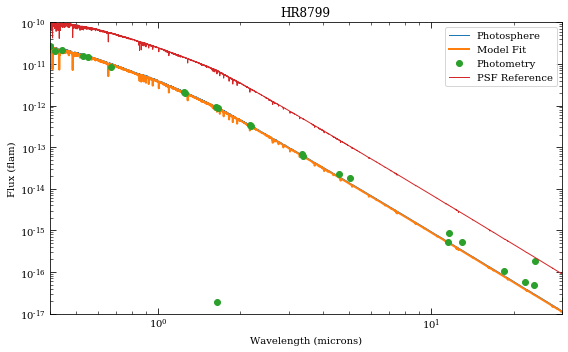

In [19]:
i = 0

name_ref, spt_ref, kmag_ref, w1_ref, w2_ref = ref_sources[i]
sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k)
sp_ref.name = name_ref

name_sci, dist_sci, fov, age, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci = args_sources[i]
vot = votdir + name_sci + '.vot'

wmin = 1e4
sp_sci, (fig,ax) = gen_sp_sci(i, robust=True, return_ax=True, wmin=wmin)

ax.plot(sp_ref.wave/1e4, sp_ref.flux, lw=1, label='PSF Reference')
ax.legend()
ax.set_xlim([0.4,30])
ax.set_ylim([1e-17,1e-10])

fname = "{}_spectra.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)

In [20]:
obs_dict = do_init(verbose=True)

F322W2 MASK430R CIRCLYOT
Generating background PSF coefficients...
Generating oversampled PSFs...
Updating NIRCam reference coefficients...
Creating NIRCam reference class...
Finished.
F444W MASK430R CIRCLYOT
Generating background PSF coefficients...
Generating oversampled PSFs...
Updating NIRCam reference coefficients...
Creating NIRCam reference class...
Finished.


In [22]:
tacq = 800
obs = obs_dict[filt_keys[0]]
do_opt(tacq, patterns=['DEEP8'], ng_min=5, nint_min=5, tacq_frac=0.1, even_nints=True)

['Pattern', 'NGRP', 'NINT', 't_int', 't_exp', 't_acq', 'SNR', 'Well', 'eff']

F322W2_MASK430R_CIRCLYOT


[     pynrc:WARNING] No ramp settings allowed within constraints! Reduce constraints.


DEEP8, 6, 6, 115.45632, 692.73792, 699.27168, 111.459341393, 1.27904148379, 4.214


[     pynrc:WARNING] No ramp settings allowed within constraints! Reduce constraints.
[     pynrc:WARNING] No ramp settings allowed within constraints! Reduce constraints.
[     pynrc:WARNING] No ramp settings allowed within constraints! Reduce constraints.
[     pynrc:WARNING] No ramp settings allowed within constraints! Reduce constraints.


DEEP8, 5, 8, 94.07552, 752.60416, 761.31584, 112.328833751, 8.24058080445, 4.071

F444W_MASK430R_CIRCLYOT
DEEP8, 8, 6, 158.21792, 949.30752, 955.84128, 86.2219337569, 0.301797242261, 2.788


[     pynrc:WARNING] No ramp settings allowed within constraints! Reduce constraints.


DEEP8, 5, 8, 94.07552, 752.60416, 761.31584, 69.8664307275, 1.42186611802, 2.532


In [24]:
# Optimize readout parameters
#do_opt(tacq, patterns='MEDIUM8', ng_min=8, ng_max=8, tacq_frac=0.1, well_levels=[2], even_nints=True)
for key in filt_keys:
    obs = obs_dict[key]

    rm = 'DEEP8'
    ng = 8 if 'F322' in key else 16
    nint_sci, nint_ref = (5,5)
    if obs.bandpass.avgwave()/1e4 < 2.5: 
        nint_sci *= 2
        nint_ref *= 2
    
    obs.update_detectors(read_mode=rm, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=rm, ngroup=ng, nint=nint_ref)

    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')


In [23]:
# Max Saturation Values
dmax = []
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    
    ng = obs.multiaccum.ngroup
    im_sat1 = obs.saturation_levels(ngroup=ng)
    im_sat2 = obs.nrc_ref.saturation_levels(obs.sp_ref, ngroup=ng)
    print(im_sat1.max(), im_sat2.max())


F322W2_MASK430R_CIRCLYOT
2.08046985069 2.84751917033
F444W_MASK430R_CIRCLYOT
0.69473523772 0.935109624497


In [24]:
# List of WFE drifts to check
wfe_list = [0,2,5,10][::-1]
nsig = 5

# Get contrasts for each WFE drift
contrast_dict = do_contrast(wfe_list, filt_keys, nsig=nsig)

F322W2_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


In [30]:
test = contrast_dict[filt_keys[0]]
len(test)

4

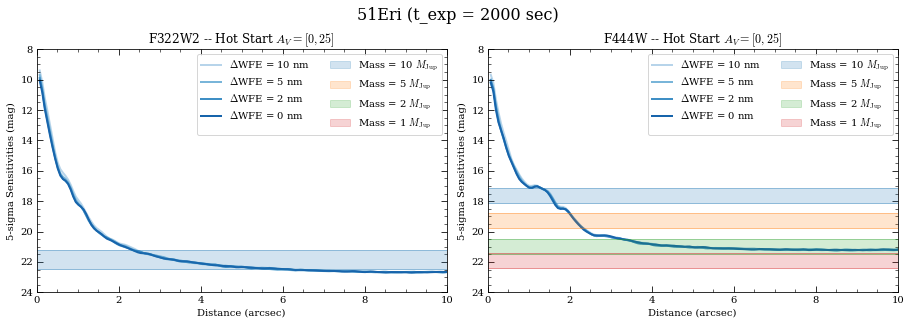

In [25]:
do_plot_contrast(obs_dict, contrast_dict, wfe_list, nsig, age, save_fig=True)

## ND Target Acquisition Times

In [26]:
nrc = pynrc.NIRCam(filter='F335M', pupil='CIRCLYOT', ND_acq=True,
                   wind_mode='WINDOW', xpix=64, ypix=64)

for i in range(len(args_sources)):

    name_sci, dist_sci, fov, age, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci = args_sources[i]
    name_ref, spt_ref, kmag_ref, w1_ref, w2_ref = ref_sources[i]

    # Science target and reference star spectra
    sp_sci = pynrc.stellar_spectrum(spt_sci, w1_sci, 'vegamag', bp_w1)
    sp_ref = pynrc.stellar_spectrum(spt_ref, w1_ref, 'vegamag', bp_w1)
    sp_sci.name = name_sci
    sp_ref.name = name_ref
    
    
    print(name_sci)

    ng_levels = [65]
    for sp in [sp_sci, sp_ref]:
        for ng in ng_levels: 
            pynrc.setup_logging('ERROR', verbose=False)
            tbl = nrc.ramp_optimize(sp, snr_goal=50, snr_frac=0.01, well_frac_max=0.5, verbose=False,
                                    ng_min=ng, ng_max=ng, nint_max=1, patterns=['SHALLOW2'])
            nrow = len(tbl)
            if nrow>0:
                print(tbl)
                break

    print('')

pynrc.setup_logging('WARNING', verbose=False)

HR8799
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
SHALLOW2     65    1     16.15     16.15     16.21    227.6    0.120   56.527



In [26]:
nrc = pynrc.NIRCam(filter='F335M', pupil='CIRCLYOT', ND_acq=True,
                   wind_mode='WINDOW', xpix=64, ypix=64)

for i in range(len(args_sources)):

    name_sci, dist_sci, fov, age, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci = args_sources[i]
    name_ref, spt_ref, kmag_ref, w1_ref, w2_ref = ref_sources[i]

    # Science target and reference star spectra
    sp_sci = pynrc.stellar_spectrum(spt_sci, w1_sci, 'vegamag', bp_w1)
    sp_ref = pynrc.stellar_spectrum(spt_ref, w1_ref, 'vegamag', bp_w1)
    sp_sci.name = name_sci
    sp_ref.name = name_ref
    
    
    print(name_sci)

    ng_levels = [65]
    for sp in [sp_sci, sp_ref]:
        for ng in ng_levels: 
            pynrc.setup_logging('ERROR', verbose=False)
            tbl = nrc.ramp_optimize(sp, snr_goal=50, snr_frac=0.01, well_frac_max=0.5, verbose=False,
                                    ng_min=ng, ng_max=ng, nint_max=1, patterns=['SHALLOW2'])
            nrow = len(tbl)
            if nrow>0:
                print(tbl)
                break

    print('')

pynrc.setup_logging('WARNING', verbose=False)

HR8799
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
SHALLOW2     65    1     16.15     16.15     16.21    227.6    0.120   56.527

